# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Union, Iterable, Callable, Optional, Any
from itertools import product
from dataclasses import dataclass

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.calibration import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(*probs) -> np.float64:
    """Calculates the entropy of the given probabilities."""

    if (len(probs) == 1) and (isinstance(probs[0], Iterable)):
        probs = probs[0]

    probs = np.array(probs, dtype=np.float64)

    assert probs.ndim == 1, "List of probabilities must be 1-dimensional"
    assert np.all(probs >= 0), "Probabilities must be non-negative"
    assert np.isclose(np.sum(probs), 1), "Probabilities must sum to 1"
    assert not np.any(np.isnan(probs)), "Probabilities cannot contain NaN"

    return -np.sum(probs * np.log(probs)) # np.log - натуральный логарифм

In [3]:
np.round(entropy(8 / 10, 2 / 10), 2)

np.float64(0.5)

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def gini(*probs) -> np.float64:
    """Calculate the Gini coefficient of a list of probabilities."""

    if (len(probs) == 1) and (isinstance(probs[0], Iterable)):
        probs = probs[0]

    probs = np.array(probs, dtype=np.float64)

    assert probs.ndim == 1, "List of probabilities must be 1-dimensional"
    assert np.all(probs >= 0), "Probabilities must be non-negative"
    assert np.isclose(np.sum(probs), 1), "Probabilities must sum to 1"
    assert not np.any(np.isnan(probs)), "Probabilities cannot contain NaN"

    return np.sum(probs * (1 - probs))

In [5]:
np.round(
    gini(8 / 10, 2 / 10)
        - 8 / 10 * gini(8 / 8, 0 / 8)
        - 2 / 10 * gini(0 / 2, 2 / 2),
    2,
)

np.float64(0.32)

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
y = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
y_pred = y.mean()
y_pred

np.float64(40.6)

Пояснение: в задаче регрессии предсказываемое значение в любой листовой вершине решающего дерева $-$ это вещественное число, определяемое как среднее значение целевой переменной для всех объектов обучающей выборки, попавших в эту вершину.

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

Так как в первой части ДЗ была написана функция для вычисления коэффициента Джини по массиву вероятностей классов, а чаще нужно получать его по собственно меткам классов, то допишем еще одну функцию, которая будет вычислять вероятности классов по меткам и после этого возвращать для них коэффициент Джини.

In [7]:
def gini_from_labels(*labels) -> np.float64:
    if (len(labels) == 1) and (isinstance(labels[0], Iterable)):
        labels = labels[0]

    labels = np.array(labels)
    assert labels.ndim == 1, "List of labels must be 1-dimensional"

    probs = np.unique(labels, return_counts=True)[1] / len(labels)
    return gini(probs)

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Вообще, в этой функции ведётся и учёт пропущенных значений в обучающей выборке: все значения `NaN` будут при любом разбиении попадать в правое поддерево, поскольку `np.nan` больше всех вещественных `numpy` чисел (в случае вещественного признака), а в случае категориального признака не существует объектов, равных `np.nan` в смысле сравнения с помощью `==` (даже `np.nan == np.nan` возвращает `False`).

In [8]:
def find_best_split(
    feature: Union[np.ndarray, pd.DataFrame],
    target: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real",
) -> Tuple[np.ndarray, np.ndarray, Any, np.float64]:
    """
    :param feature: вектор значений признака (категории либо числа)
    :param target: вектор целевых значений объектов (метки классов либо числа), len(feature) == len(target)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки или поддерева
    :return q_values: вектор со значениями критерия информативности для каждого из порогов в thresholds, len(q_values) == len(thresholds)
    :return threshold_best: оптимальный порог (или значение категориального признака)
    :return q_best: наилучшее значение критерия информативности (число)
    """

    feature = np.array(feature)
    target = np.array(target)

    assert feature.ndim == 1, f"Feature must be a 1-dimensional vector, got {feature.ndim}-dimensional"
    assert target.ndim == 1, f"Target must be a 1-dimensional vector, got {target.ndim}-dimensional"

    assert len(feature) > 0, "There must be at least one feature value"
    assert len(feature) == len(target), f"Feature and target must have the same number of samples, got {len(feature)} and {len(target)}"

    assert np.isnan(target).sum() == 0, "There must be no NaN values in the target array"
    assert np.isinf(target).sum() == 0, "There must be no infinite values in the target array"

    assert task in ("classification", "regression"), "Only classification and regression are supported"
    assert feature_type in ("real", "categorical"), "Only real and categorical features are supported"

    if (len(np.unique(feature)) == 1):
        return np.array([]), np.array([]), None, np.float64(-np.inf) # Нельзя разделить на две подвыборки, если все значения признака одинаковы

    if task == "regression":
        h = np.var # Дисперсия значений целевой переменной
    else:
        h = gini_from_labels # Коэффициент Джини для меток классов

    if feature_type == "real":
        feature = np.array(feature, dtype=np.float64)
        sorted_feature = np.unique(feature) # np.unique сразу возвращает отсортированный вектор без повторов
        sorted_feature[np.isnan(sorted_feature)] = np.inf # Для возможности отделения всех NaN в правое поддерево принудительно добавим порог np.inf
        thresholds = (sorted_feature[:-1] + sorted_feature[1:]) / 2
        left_lmbd = lambda threshold: feature <= threshold
    else:
        thresholds = np.unique(feature)
        left_lmbd = lambda val: feature == val # Сравнение с np.nan всегда False

    h_init = h(target)
    feature_count = len(feature)

    # Q Value - критерий информативности
    def calc_q_value(mask: np.ndarray) -> np.floating:
        left = target[mask]
        right = target[~mask]

        # Если порог np.inf (вещественный признак), то все объекты попали в левое поддерево
        # Если порог np.nan (категориальный признак), то все объекты попали в правое поддерево
        # Оба варианта не имеет смысла рассматривать - установим критерий информативности в -np.inf
        if len(left) == 0 or len(right) == 0:
            return np.float64(-np.inf)

        return h_init - len(left) * h(left) / feature_count - len(right) * h(right) / feature_count

    # Небольшой трюк для применения векторизованных операций с массивом thresholds поэлементно
    # (Здесь thresholds точно не пуст)
    thresholds_broadcasted = np.broadcast_to(thresholds, (feature_count, len(thresholds)))

    masks = np.apply_along_axis(left_lmbd, 0, thresholds_broadcasted)
    q_values = np.apply_along_axis(calc_q_value, 0, masks)

    return thresholds, q_values, thresholds[q_values.argmax()], q_values.max()

Эту функцию можно протестировать на датасете `California`.

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894], shape=(20640,))

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [11]:
t, q, best_t, best_q = find_best_split(X["MedInc"], y, "regression", "real")

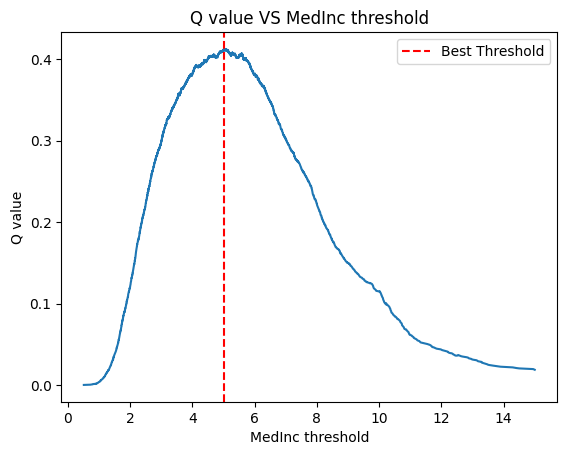

Best Threshold = 5.035
Best Q Value = 0.41275


In [12]:
ax = plt.figure().subplots(1)

ax.plot(t, q)
ax.set_title("Q value VS MedInc threshold")
ax.set_xlabel("MedInc threshold")
ax.set_ylabel("Q value")
ax.axvline(best_t, linestyle="--", color="red", label="Best Threshold")
ax.legend()

plt.show()

print(f"Best Threshold = {best_t:.3f}\nBest Q Value = {best_q:.5f}")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

MedInc: 	Best Threshold = 5.035  	Best Q Value = 0.41275
HouseAge: 	Best Threshold = 51.500  	Best Q Value = 0.03090
AveRooms: 	Best Threshold = 6.374  	Best Q Value = 0.15921
AveBedrms: 	Best Threshold = 1.103  	Best Q Value = 0.01525
Population: 	Best Threshold = 1160.500  	Best Q Value = 0.00283
AveOccup: 	Best Threshold = 3.113  	Best Q Value = 0.07392
Latitude: 	Best Threshold = 37.935  	Best Q Value = 0.09033
Longitude: 	Best Threshold = -121.865  	Best Q Value = 0.05021


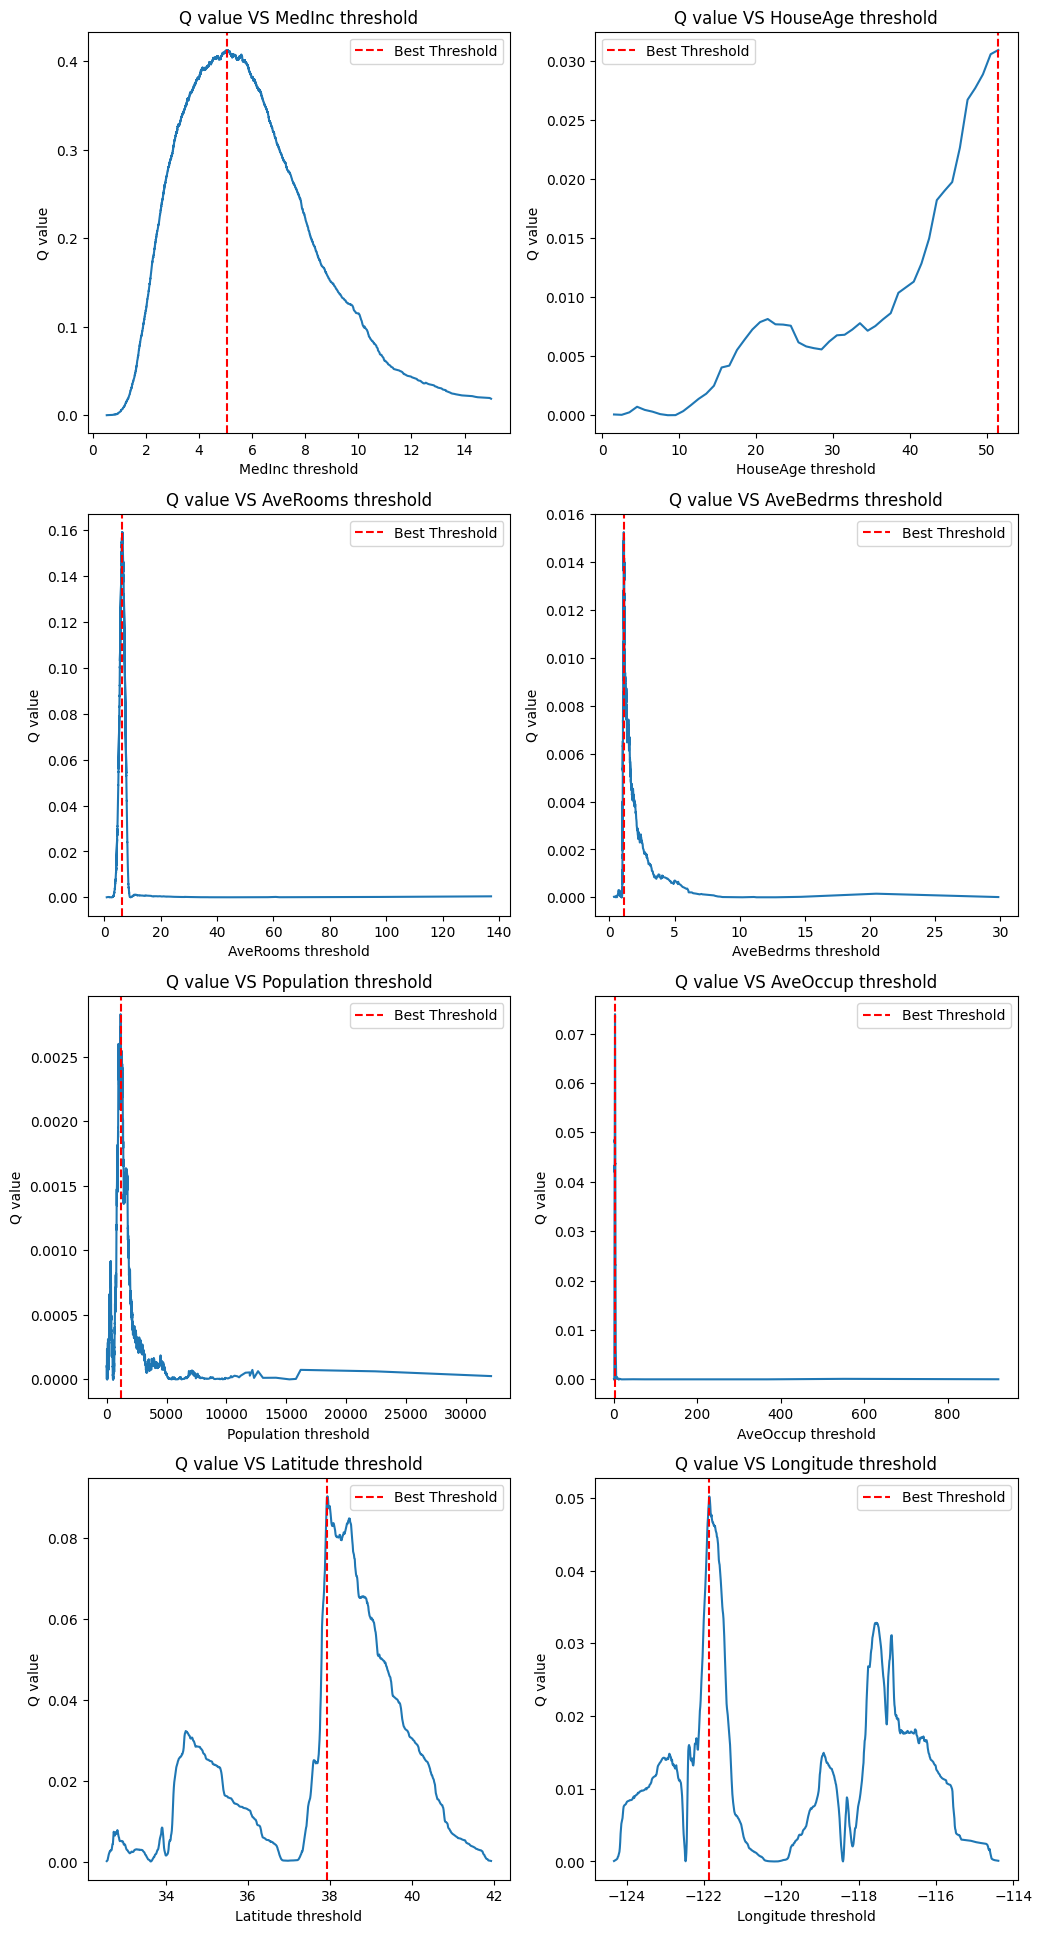

In [13]:
fig = plt.figure(figsize=(12, 24))

for i, col in enumerate(X.columns):
    t, q, best_t, best_q = find_best_split(X[col], y, "regression", "real")

    ax = fig.add_subplot(4, 2, i + 1)
    ax.plot(t, q)
    ax.set_title(f"Q value VS {col} threshold")
    ax.set_xlabel(f"{col} threshold")
    ax.set_ylabel("Q value")
    ax.axvline(best_t, linestyle="--", color="red", label="Best Threshold")
    ax.legend()

    print(f"{col}: \tBest Threshold = {best_t:.3f}  \tBest Q Value = {best_q:.5f}")

plt.subplots_adjust(hspace=0.2)
plt.show();

Наибольший `Q Value` при лучшем пороге у самого первого признака `MedInc`, так что в качестве предиката корневой вершины решающего дерева имеет смысл выбрать $\text{MedInc} \le 5.035$.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [14]:
@dataclass
class Node:
    depth: int = 1
    is_leaf: bool = False

    result_value: Optional[Any] = None

    split_feature: Optional[int] = None
    split_predicate: Optional[Callable] = None

    left_child: Optional["Node"] = None
    right_child: Optional["Node"] = None

Поскольку использование `dict` для узлов дерева мне показалось нецелосообразным, я написал отдельный класс `Node`.

Использование критерия Джини уже заложено в методе `find_best_split`, также как и учёт пропусков в данных.

`Feature Importance` расчитывается просто как сумма всех увеличений критерия информативности по всем вершинам, где использовался предикат с конкретным признаком.

Ну и да, все операции максимально векторизованы, а вызов `find_best_split` сделан не через `for`, а в `map`.

И сори что почти полностью переписал код дерева :)

In [15]:
class DecisionTree:
    __root: Node
    feature_importances_: np.ndarray


    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        task: str = "classification",
        max_depth: Optional[int] = None,
        min_samples_split: Optional[int] = None,
        min_samples_leaf: Optional[int] = None,
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._feature_types = np.array(feature_types)

        if task not in ("classification", "regression"):
            raise ValueError("Only classification and regression tasks are supported")

        self.task = task

        self._max_depth = max(1, int(max_depth)) if max_depth is not None else None
        self._min_samples_split = max(2, int(min_samples_split)) if min_samples_split is not None else None
        self._min_samples_leaf = max(1, int(min_samples_leaf)) if min_samples_leaf is not None else None


    # Служебная функция, чтобы вынести повторяющееся вычисление значение ответа для листовой вершины
    def _calculate_leaf_value(self, y: np.ndarray) -> Any:
        if self.task == "regression":
            return np.mean(y)
        else:
            unique, counts = np.unique(y, return_counts=True)
            return unique[np.argmax(counts)]


    def _fit_node(self, node: Node, X: np.ndarray, y: np.ndarray) -> None:
        if node.depth == self._max_depth or len(np.unique(y)) == 1 or self._min_samples_split is not None and len(y) < self._min_samples_split:
            node.is_leaf = True
            node.result_value = self._calculate_leaf_value(y)
            return

        # Немного магии Python: ленивый итератор map позволяет не хранить все перебираемые threshold и q_value в памяти
        split_feature, threshold, best_q = max(
            map(
                lambda f: (f[0], *find_best_split(X[:, f[0]], y, self.task, f[1])[2:]),
                enumerate(self._feature_types),
            ),
            key=lambda tpl: tpl[-1], # type: ignore (здесь Pylance не знает, что tpl - это кортеж)
        )
        # По факту работа с пропусками идёт в find_best_split: объекты с пропущенным значением признака всегда будут уходить в правое поддерево

        # Если не нашлось порога, улучшающего критерий информативности, то делаем вершину листовой
        if best_q <= 0:
            node.is_leaf = True
            node.result_value = self._calculate_leaf_value(y)
            return

        if self._feature_types[split_feature] == "real":
            node.split_predicate = lambda x: x <= threshold
        else:
            node.split_predicate = lambda x: x == threshold

        mask = node.split_predicate(X[:, split_feature])

        if not(self._min_samples_leaf is None or self._min_samples_leaf <= mask.sum() <= X.shape[1] - self._min_samples_leaf):
            node.split_predicate = None
            node.is_leaf = True
            node.result_value = self._calculate_leaf_value(y)
            return

        # Feature importance - суммарное увеличение критерия информативности при использовании этого признака
        self.feature_importances_[split_feature] += best_q

        node.split_feature = split_feature

        node.left_child = Node(node.depth + 1)
        node.right_child = Node(node.depth + 1)

        self._fit_node(node.left_child, X[mask], y[mask])
        self._fit_node(node.right_child, X[~mask], y[~mask])


    def _predict_node(self, x: np.ndarray, node: Node) -> Any:
        if node.is_leaf:
            return node.result_value

        if node.split_predicate(x[node.split_feature]):
            return self._predict_node(x, node.left_child)

        return self._predict_node(x, node.right_child)


    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None:
        X = np.array(X)
        y = np.array(y)

        assert X.ndim == 2, f"X must be 2-dimensional, got {X.ndim}-dimensional"
        assert y.ndim == 1, f"y must be 1-dimensional, got {y.ndim}-dimensional"

        assert X.shape[0] == y.shape[0], f"X and y must have the same number of samples, got {X.shape[0]} and {y.shape[0]}"
        assert len(self._feature_types) == X.shape[1], f"X must have {len(self._feature_types)} features, got {X.shape[1]}"

        assert X.shape[0] > 0, "There must be at least one sample in X"
        assert np.isnan(y).sum() == 0, "There must be no NaN values in y"
        assert np.isinf(y).sum() == 0, "There must be no infinite values in y"

        self.__root = Node()
        self.feature_importances_ = np.zeros(len(self._feature_types), dtype=np.float64)

        self._fit_node(self.__root, X, y)


    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        X = np.array(X)

        assert X.ndim == 2, f"X must be 2-dimensional, got {X.ndim}-dimensional"
        assert len(self._feature_types) == X.shape[1], f"X must have {len(self._feature_types)} features, got {X.shape[1]}"
        assert X.shape[0] > 0, "There must be at least one sample in X"

        # __root ещё не инициализирован => дерево не построено (модель не обучена)
        assert hasattr(self, "_DecisionTree__root"), "The decision tree has not been fitted yet"

        return np.apply_along_axis(self._predict_node, 1, X, self.__root)


    def get_feature_importances(self) -> np.ndarray:
        assert hasattr(self, "_DecisionTree__root"), "The decision tree has not been fitted yet"
        return self.feature_importances_

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [16]:
data = pd.read_csv("students.csv", index_col=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

display(X.sample(5))
display(y.sample(5))

y.value_counts()

,STG,SCG,STR,LPR,PEG
24,0.060,0.29,0.35,0.76,0.25
248,0.890,0.68,0.49,0.65,0.90
59,0.080,0.58,0.60,0.64,0.10
87,0.270,0.31,0.32,0.41,0.28
126,0.299,0.70,0.95,0.22,0.66


49     1
111    0
186    1
62     1
249    1
Name: UNS, dtype: int64

UNS
1    151
0    107
Name: count, dtype: int64

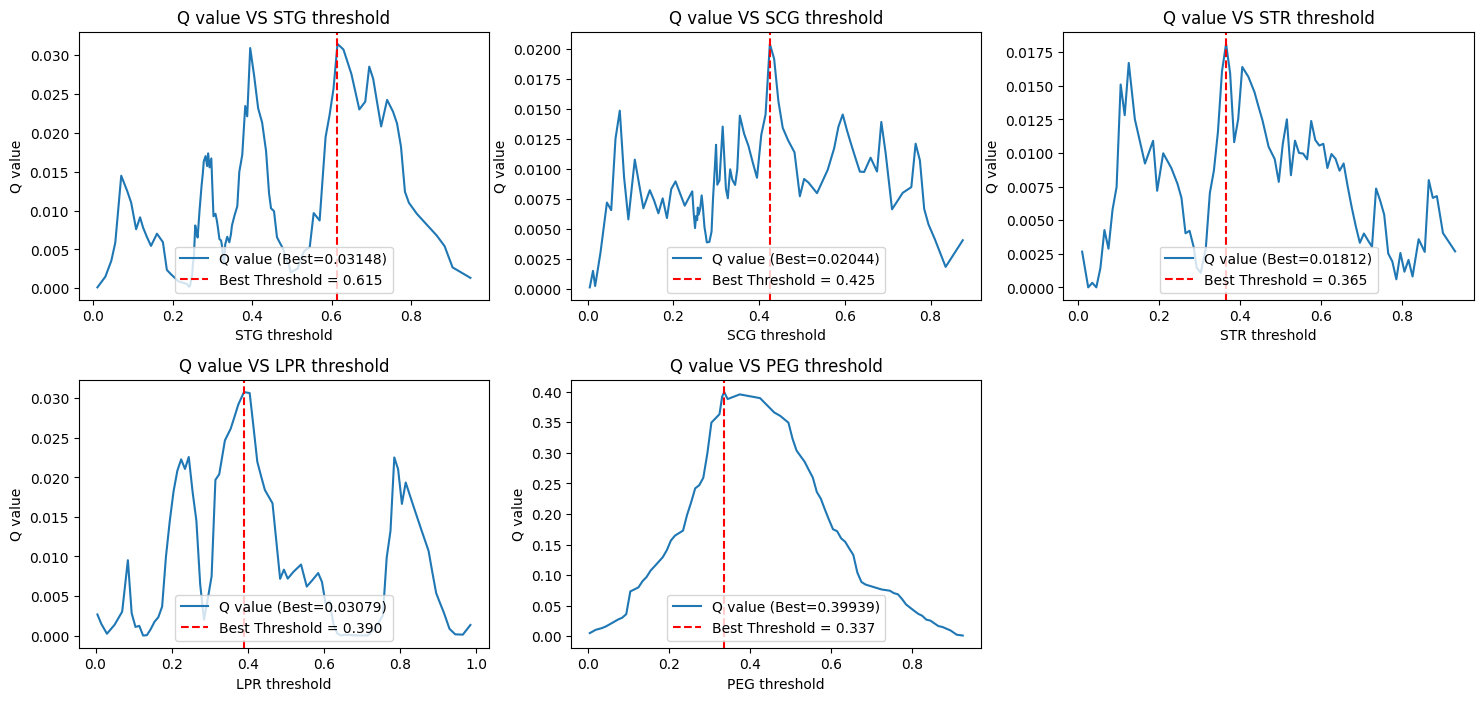

In [17]:
fig = plt.figure(figsize=(18, 8))

for i, col in enumerate(X.columns):
    t, q, best_t, best_q = find_best_split(X[col], y, "classification", "real")

    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(t, q, label=f"Q value (Best={best_q:.5f})")
    ax.set_title(f"Q value VS {col} threshold")
    ax.set_xlabel(f"{col} threshold")
    ax.set_ylabel("Q value")
    ax.axvline(best_t, linestyle="--", color="red", label=f"Best Threshold = {best_t:.3f}")
    ax.legend(loc="lower center")

plt.subplots_adjust(hspace=0.3)
plt.show();

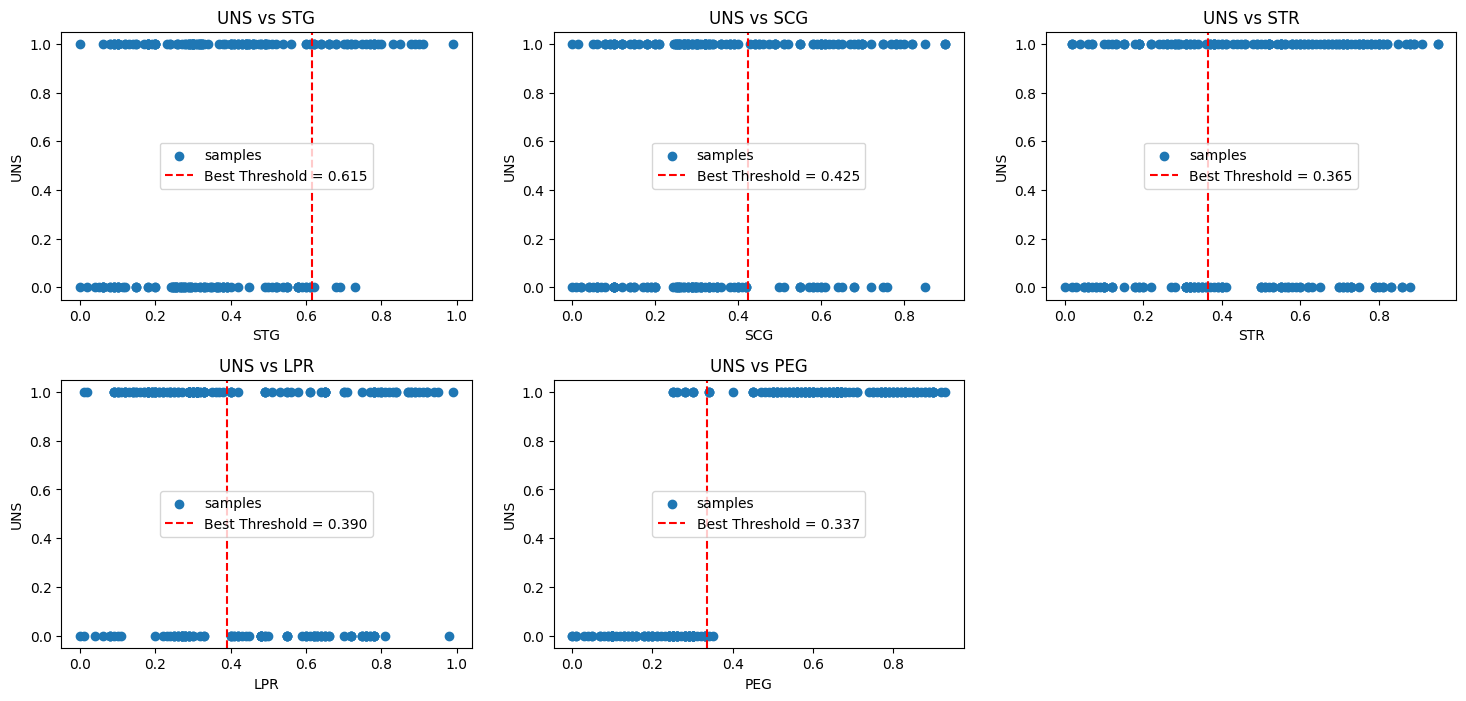

In [18]:
fig = plt.figure(figsize=(18, 8))

for i, col in enumerate(X.columns):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.scatter(X[col], y, label="samples")

    _, _, best_t, _ = find_best_split(X[col], y, "classification", "real")

    ax.axvline(best_t, linestyle="--", color="red", label=f"Best Threshold = {best_t:.3f}")
    ax.set_title(f"{y.name} vs {col}")
    ax.set_xlabel(col)
    ax.set_ylabel(y.name)
    ax.legend(loc="center")

plt.subplots_adjust(hspace=0.3)
plt.show();

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Из всех признаков только пятый (`PEG`) действительно визуально хорошо разделяет выборку по целевой переменной (`UNS`). Это подтверждается и графиком критерия информативности $-$ он куполообразный с выделенным пиком при `threshold = 0.337`, причём по абсолютному значению критерия информативности при лучшем разбиении этот признак также лучший среди пяти рассматриваемых.

Можно сделать вывод, что для "хороших" признаков, по которым выборка делится практически идеально, также характерны куполообразные графики критерия информативности в зависимости от порога разделения, с одним выделенным максимумом. Для признаков, по которым деление практически невозможно, графики критерия информативности в зависимости от порога разделения будут иметь более случайную структуру с несколькими экстремумами.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [19]:
data = pd.read_csv("agaricus-lepiota.data", header=None)

for col in data.columns:
    data[col] = np.array(LabelEncoder().fit_transform(data[col]), dtype=np.int8)
# Первый столбец (целевая переменная) - бинарный признак, там будут только 0 и 1

X, y = data.iloc[:, 1:], data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=4856)

tree = DecisionTree(feature_types=np.array(["categorical"] * X.shape[1]), task="classification")
tree.fit(X_train, y_train)

print(f"Accuracy on train: {accuracy_score(y_train, tree.predict(X_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, tree.predict(X_test)):.3f}")

Accuracy on train: 1.000
Accuracy on test: 0.999


Поскольку не было задано ограничений ни на глубину дерева, ни на число объектов в листовых вершинах, очевидно, `accuracy` на `train` равна единице (во всех листовых вершинах объекты ровно одного класса).

Однако переобучения не произошло (видимо, особенность датасета) $-$ `accuracy` на `test` тоже почти единица $(0.999)$.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [20]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

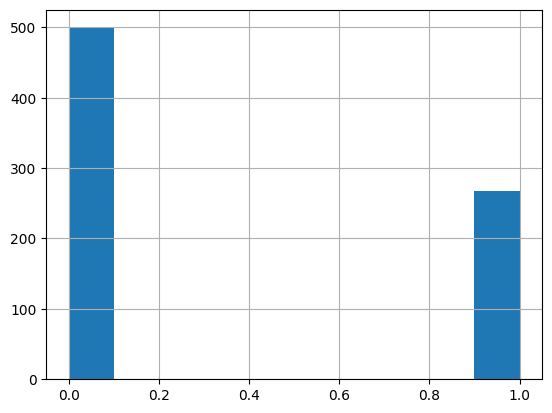

In [21]:
data['Outcome'].hist()
plt.show();

К счастью, в датасете пациентов с диабетом меньше, чем здоровых. Однако из-за этого нужно будет следить за соотношением классов при разбиении выборки на тренировочную и тестовую...

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [22]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=456, stratify=y_train_full)

X_train.shape, X_test.shape, X_val.shape

((375, 8), (231, 8), (162, 8))

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [23]:
depth_values = np.arange(1, 101)
leaf_sizes = np.arange(1, 101)

best = -1
best_hp = (0, 0)

for max_depth, min_samples_leaf in product(depth_values, leaf_sizes):
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=0,
    ).fit(X_train, y_train)

    f1 = f1_score(y_val, tree.predict(X_val))

    if f1 > best:
        best = f1
        best_hp = (max_depth, min_samples_leaf)

        print(f"max_depth = {max_depth}\tmin_samples_leaf = {min_samples_leaf}\tf1 = {f1:.5f}")

max_depth, min_samples_leaf = best_hp

max_depth = 1	min_samples_leaf = 1	f1 = 0.63830
max_depth = 1	min_samples_leaf = 85	f1 = 0.65263
max_depth = 1	min_samples_leaf = 93	f1 = 0.67347
max_depth = 1	min_samples_leaf = 97	f1 = 0.70588
max_depth = 4	min_samples_leaf = 44	f1 = 0.73874


In [24]:
tree = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=0,
).fit(X_train_full, y_train_full)

for metric in (accuracy_score, precision_score, recall_score, roc_auc_score):
    print(f"{" ".join(metric.__name__.split('_')[:-1]).title()}: \t{metric(y_test, tree.predict(X_test)):.5f}")

Accuracy: 	0.74026
Precision: 	0.62651
Recall: 	0.64198
Roc Auc: 	0.71765


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [25]:
bc = BaggingClassifier(
    n_estimators=50,
    random_state=0,
    n_jobs=-1,
).fit(X_train_full, y_train_full)

for metric in (accuracy_score, precision_score, recall_score, roc_auc_score):
    print(f"{" ".join(metric.__name__.split('_')[:-1]).title()}: \t{metric(y_test, bc.predict(X_test)):.5f}")

Accuracy: 	0.75758
Precision: 	0.66234
Recall: 	0.62963
Roc Auc: 	0.72815


По сравнению с `DecisionTreeClassifier` у `BeggingClassifier` немного снизилась `recall`, тогда как все остальные метрики выросли, хотя и не намного.

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [26]:
depth_values = np.arange(1, 101)
leaf_sizes = np.arange(2, 101)

best = -1
best_hp = (0, 0)

for max_depth, min_samples_split in product(depth_values, leaf_sizes):
    rf = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=50,
        random_state=0,
        n_jobs=-1,
    )

    f1 = cross_val_score(rf, X_train_full, y_train_full, cv=5, scoring="f1", n_jobs=-1).mean()

    if f1 > best:
        best = f1
        best_hp = (max_depth, min_samples_split)

        print(f"max_depth = {max_depth}\tmin_samples_split = {min_samples_split}\tf1 = {f1:.5f}")

max_depth, min_samples_split = best_hp

max_depth = 1	min_samples_split = 2	f1 = 0.10739
max_depth = 2	min_samples_split = 2	f1 = 0.44135
max_depth = 2	min_samples_split = 81	f1 = 0.44203
max_depth = 2	min_samples_split = 90	f1 = 0.44660
max_depth = 3	min_samples_split = 2	f1 = 0.50420
max_depth = 3	min_samples_split = 3	f1 = 0.50602
max_depth = 3	min_samples_split = 4	f1 = 0.50769
max_depth = 3	min_samples_split = 6	f1 = 0.50916
max_depth = 3	min_samples_split = 9	f1 = 0.51207
max_depth = 3	min_samples_split = 11	f1 = 0.51344
max_depth = 3	min_samples_split = 12	f1 = 0.51506
max_depth = 3	min_samples_split = 14	f1 = 0.51753
max_depth = 3	min_samples_split = 15	f1 = 0.52166
max_depth = 3	min_samples_split = 17	f1 = 0.52373
max_depth = 3	min_samples_split = 20	f1 = 0.52906
max_depth = 3	min_samples_split = 25	f1 = 0.53471
max_depth = 3	min_samples_split = 44	f1 = 0.53544
max_depth = 4	min_samples_split = 2	f1 = 0.55357
max_depth = 4	min_samples_split = 5	f1 = 0.56501
max_depth = 4	min_samples_split = 11	f1 = 0.57359
max_depth

In [27]:
rf = RandomForestClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    n_estimators=50,
    random_state=0,
    n_jobs=-1,
).fit(X_train_full, y_train_full)

for metric in (accuracy_score, precision_score, recall_score, roc_auc_score):
    print(f"{" ".join(metric.__name__.split('_')[:-1]).title()}: \t{metric(y_test, rf.predict(X_test)):.5f}")

Accuracy: 	0.75325
Precision: 	0.70690
Recall: 	0.50617
Roc Auc: 	0.69642


У `RandomForestClassifier` по сравнению с `BeggingClassifier` выросла `precision`, но вот остальные метрики упали.

По `accuracy` и `ROC AUC` лучшей моделью оказался `BeggingClassifier`, по `precision` выиграл `RandomForestClassifier`, а вот по `recall` лучшим оказалось одно простое решающее дерево `DecisionTreeClassifier`. Соответственно, в зависимости от требований к метрике (какая важнее), стоит выбирать либо простое решающее дерево, либо уже ансамбли решающих деревьев $-$ бэггинг или случайный лес.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [28]:
counts = np.arange(1, 1001)

scores = [
    roc_auc_score(
        y_test,
        RandomForestClassifier(
            n_estimators=count,
            random_state=0,
            n_jobs=-1,
        ).fit(
            X_train_full,
            y_train_full,
        ).predict(
            X_test,
        ),
    )
    for count in counts
]

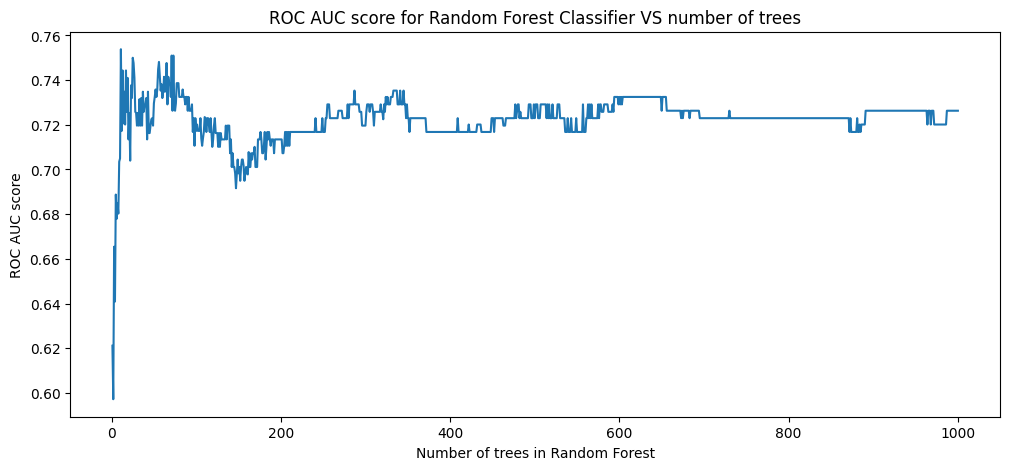

In [29]:
ax = plt.figure(figsize=(12, 5)).add_subplot(111)
ax.plot(counts, scores)
ax.set_title("ROC AUC score for Random Forest Classifier VS number of trees")
ax.set_xlabel("Number of trees in Random Forest")
ax.set_ylabel("ROC AUC score")
plt.show();

Судя по графику, есть ощущение некоторой стабилизации результатов обучения случайного леса с ростом числа деревьев. При этом отдельные значения `n_estimators` в районе $30$-$100$ дают даже лучший `ROC AUC`, чем случайный лес с несколькими сотнями деревьев.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

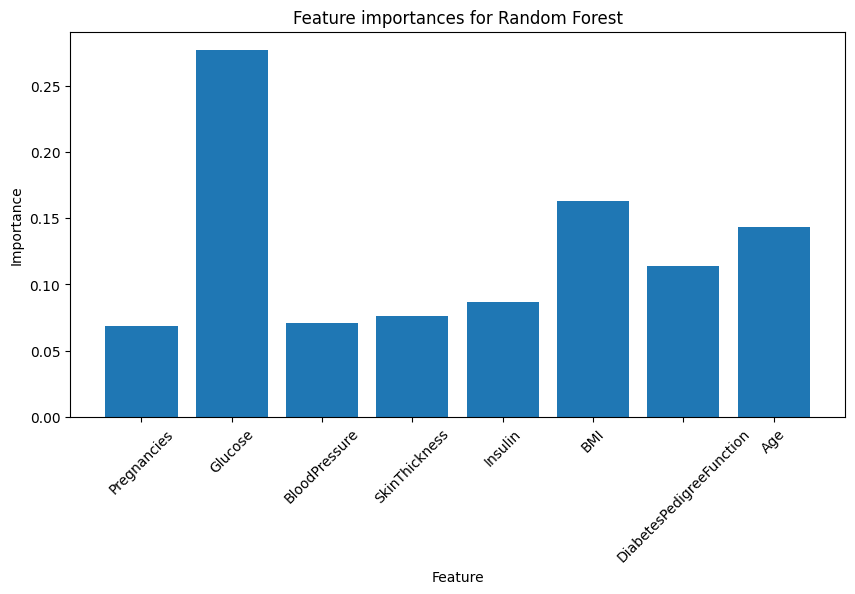

In [30]:
importances = rf.feature_importances_

ax = plt.figure(figsize=(10, 5)).add_subplot(111)
ax.bar(X.columns, importances, align="center")
ax.set_title("Feature importances for Random Forest")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.tick_params(axis="x", rotation=45)
plt.show();

Достаточно неудивительно, что наиболее важным признаком для определения диабета оказался уровень глюкозы. Несколько менее важны возраст человека и параметр `BMI` (индекс массы тела человека), тогда как уровень инсулина и другие показатели оказались совсем неважными (относительно).